**HOME CREDIT DEFAULT RISK COMPETITION**: Le projet s'inscrit dans le cadre d'une compétition sur la prédiction du risque de défaut de crédit. Home Credit est une institution financière qui propose des prêts à des clients n'ayant pas ou peu d'historique de crédit.

**Objectif**: Construire un modèle capable de prédire la probabilité qu'un client ne rembourse pas son prêt (défaut de crédit) en fonction de diverses informations.

In [ ]:
!pip install imblearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytest-ngrok

In [ ]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
!pip install shap
!pip install hyperopt
!pip install scikit-learn --upgrade
!pip install scikit-optimize --upgrade
!pip install catboost
!pip install mlflow -q
!pip install pyngrok -q
!pip install -U kaleido
!pip install pytest-ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 28.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score,adjusted_rand_score,precision_score, recall_score, f1_score
import shap
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from imblearn.ensemble import BalancedRandomForestClassifier
import plotly.graph_objects as go
import gc
import time
import plotly.express as px
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score,adjusted_rand_score,precision_score, recall_score, f1_score
import shap
from sklearn.impute import SimpleImputer
import time
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier
import joblib
import mlflow

from mlflow.models.signature import infer_signature
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install scikit-optimize

#Feature engineering

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/content/drive/MyDrive/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/content/drive/MyDrive/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df])
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/content/drive/MyDrive/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('/content/drive/MyDrive/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg.reset_index()

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/content/drive/MyDrive/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg.reset_index()

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/content/drive/MyDrive/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg.reset_index()

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/content/drive/MyDrive/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg.reset_index()

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/content/drive/MyDrive/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg.reset_index()



#Création du score métier

In [ ]:
#Cout total
cost_matrix = {
    'FN': 10,  # Coût d'un faux négatif
    'FP': 1   # Coût d'un faux positif
}
def calculate_total_cost(y_true, y_pred, threshold, cost_matrix):
    """
    Calcule le coût total des erreurs de prédiction.

    Args:
        y_true: Les vraies étiquettes (0 ou 1).
        y_pred: Les probabilités prédites (valeurs entre 0 et 1).
        threshold: Le seuil de classification (valeur entre 0 et 1).
            Si la probabilité prédite est supérieure ou égale au seuil,
            l'observation est classée comme positive (1), sinon négative (0).
        cost_matrix: Un dictionnaire contenant les coûts associés aux faux négatifs (FN) et aux faux positifs (FP).
            Exemple : {'FN': 10, 'FP': 1} signifie qu'un faux négatif coûte 10 et un faux positif coûte 1.

    Returns:
        Le coût total, calculé comme la somme des coûts des faux négatifs et des faux positifs.
    """

    # Convertir les probabilités prédites en classes (0 ou 1) en utilisant le seuil.
    y_pred_class = (y_pred >= threshold).astype(int)

    # Calculer le nombre de faux négatifs (FN):
    # observations qui sont positives en réalité (y_true == 1)
    # mais classées comme négatives par le modèle (y_pred_class == 0).
    FN = np.sum((y_true == 1) & (y_pred_class == 0))

    # Calculer le nombre de faux positifs (FP):
    # observations qui sont négatives en réalité (y_true == 0)
    # mais classées comme positives par le modèle (y_pred_class == 1).
    FP = np.sum((y_true == 0) & (y_pred_class == 1))

    # Calculer le coût total en utilisant la matrice de coût.
    total_cost = int(FN) * cost_matrix['FN'] + int(FP) * cost_matrix['FP']

    return total_cost

##Optimisation du score métier

In [ ]:
def optimize_threshold_and_metrics(y_true, y_pred_proba, cost_matrix):
    """
    Optimise le seuil de classification et calcule des métriques de performance
    importantes, notamment le score métier, l'AUC et l'accuracy.

    Args:
        y_true: Les vraies étiquettes (valeurs réelles) des données.
        y_pred_proba: Les probabilités prédites par le modèle pour chaque donnée.
        cost_matrix: La matrice de coût définissant les coûts associés
                     aux différentes erreurs de classification
                     (faux positifs, faux négatifs).

    Returns:
        Un dictionnaire contenant les informations suivantes :
            - optimal_threshold : le seuil optimal qui minimise le coût total.
            - business_score : le score métier, qui représente le coût total minimal.
            - auc_score : l'aire sous la courbe ROC (AUC), une mesure de la performance globale du modèle.
            - accuracy : l'accuracy (exactitude), le pourcentage de prédictions correctes.
    """

    # Générer une liste de seuils possibles entre 0 et 1
    thresholds = np.linspace(0, 1, 101)

    # Calculer le coût total pour chaque seuil
    costs = [calculate_total_cost(y_true, y_pred_proba, t, cost_matrix) for t in thresholds]

    # Trouver le seuil qui minimise le coût total
    optimal_threshold = thresholds[np.argmin(costs)]

    # Le score métier est le coût total minimal
    best_model_score = min(costs)

    # Calculer l'AUC
    auc_score = roc_auc_score(y_true, y_pred_proba)

    # Calculer l'accuracy en utilisant le seuil optimal
    accuracy = accuracy_score(y_true, (y_pred_proba >= optimal_threshold).astype(int))

    # Retourner les résultats dans un dictionnaire
    return {
        'optimal_threshold': optimal_threshold,
        'business_score': best_model_score,
        'auc_score': auc_score,
        'accuracy': accuracy
    }

#Standardisation et imputation  des valeurs manquantes

In [ ]:

#Standardization et imputation
def impute_and_standardize(X):
    """Impute les valeurs manquantes et standardise les données.

    Args:
        X: DataFrame contenant les données à imputer et standardiser.

    Returns:
        DataFrame avec les valeurs manquantes imputées et les données standardisées.
    """

    # Créer une copie de X pour éviter de modifier les données d'origine
    X_imputed = X.copy()

    # Replace infinite values with NaNs
    X_imputed = X_imputed.replace([np.inf, -np.inf], np.nan)

    # Imputer les valeurs manquantes avec la médiane pour les variables numériques
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X_imputed)

    # Standardiser les données numériques
    scaler = StandardScaler()
    X_scaled= scaler.fit_transform(X_imputed)

    return X_scaled


#Les modèles

In [ ]:
def train_and_evaluate_models(X_scaled, y, cost_matrix):
    """Entraîne et évalue plusieurs modèles avec BayesianOptimization."""
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.3, random_state=101
    )

    # Define models and their hyperparameter spaces using skopt.space objects
    models = {
        "LogisticRegression": {
            "model": LogisticRegression( verbose=1,max_iter=1000),
            "params": {
                "C": Real(0.01, 10, prior="log-uniform"),
                "class_weight":Categorical(["balanced",None]),
                }
        },
        "RandomForestClassifier": {
            "model": RandomForestClassifier( verbose=1),
            "params": {
                "n_estimators": Integer(100, 200),  # Use Integer for discrete values
                "max_depth": Integer(5, 10),
                "class_weight":Categorical(["balanced",None]),
            },
        },

        "Balanced Random Forest":{
            "model":BalancedRandomForestClassifier(verbose=1,class_weight="balanced"),
            "params":{
                "n_estimators": Integer(100, 1000),
                "max_depth": Integer(5, 20),
               "min_samples_split": Integer(2, 20),
               "min_samples_leaf": Integer(1, 20),
                "class_weight":Categorical(["balanced",None]),

            },
         },
        "CatBoostClassifier": {
            "model": CatBoostClassifier(verbose=1),
            "params": {
                "iterations": Integer(100, 1000),
                "learning_rate": Real(0.01, 0.1, prior="log-uniform"),
                "depth": Integer(4, 10),
                "l2_leaf_reg": Real(1, 10, prior="log-uniform"),
                "border_count": Integer(32, 255),
                "auto_class_weights": Categorical(["Balanced", 'None']),  # Équilibre des classes
            },
        }

    }


    # Loop over the models and perform BayesianOptimization
    best_model = None
    best_score = float("inf")
    results = []
    for model_name, model_data in models.items():
        start_time = time.time()

        # Define a target function that includes the threshold optimization
        def target_function(params, model_name=model_name):  # Add model_name here
            model = models[model_name]["model"]  # Access model using model_name
            model.set_params(**params)
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            # Optimize threshold and calculate business score within target_function
            optimized_metrics = optimize_threshold_and_metrics(
                y_val, y_pred_proba, cost_matrix
            )
            return optimized_metrics["business_score",]

        # Include model_name in the target function arguments
        # Use search_spaces and estimator instead of f
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

        bayes_search = BayesSearchCV(
            model_data["model"],
            model_data["params"],
            n_iter=3,  # Number of iterations
            # Remove business_scorer here: scoring=business_scorer,
            cv=cv,
            n_jobs=-1,  # Use all available cores
            random_state=101,  # Set random state for reproducibility
            )
        # Modify the scoring parameter to use 'roc_auc'
        bayes_search.scoring = 'roc_auc'

            # Fit other models without sample weights
        bayes_search.fit(X_train, y_train)

        # Best model
        best_model_params = bayes_search.best_params_
        best_model = bayes_search.best_estimator_
        best_model.fit(X_train, y_train)

        # Predictions using the best model
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        y_pred_train = best_model.predict(X_train)
        y_pred_val = best_model.predict(X_val)

        # Évaluer les performances sur l'ensemble de test
        optimized_metrics = optimize_threshold_and_metrics(y_val, y_pred_proba, cost_matrix)
        end_time = time.time()  # Fin du chronométrage
        execution_time = end_time - start_time

        results.append(
            { "Modèle": model_name,
                "Score métier": optimized_metrics["business_score"],
                "Accuracy Train": accuracy_score(y_train, y_pred_train),
                "Accuracy Val": accuracy_score(y_val, y_pred_val),
                "precision": precision_score(y_val, y_pred_val),
                "recall": recall_score(y_val, y_pred_val),
                "f1": f1_score(y_val, y_pred_val),
                "Temps d'exécution": execution_time,
                "AUC": optimized_metrics["auc_score"], } )
        df_results = pd.DataFrame(results)
        if optimized_metrics["business_score"] < best_score:
            best_score = optimized_metrics["business_score"]
            best_model = best_model
    return best_model, df_results, best_model_params

#Comparaison des résultats

In [ ]:
def visualiser_resultats(df_results):
  """
  Génère et affiche trois graphiques pour visualiser les résultats des modèles :

  1. Un graphique à barres comparant les scores métiers des modèles.
  2. Un graphique de courbes ROC et AUC pour chaque modèle.
  3. Un graphique en boîte comparant les temps d’exécution des modèles.

  Args :
    df_results : Un DataFrame contenant les résultats des modèles,
                 y compris les colonnes « Modèle », « Score métier »,
                 « AUC » et « Temps d’exécution ».

  Returns :
    None. Les graphiques sont affichés directement.
  """
  # Graphique à barres pour les scores métiers
  fig1 = px.bar(df_results, x='Modèle', y='Score métier', color='Modèle',
               title='Comparaison des scores métiers des modèles')
  fig1.show()

  # Graphique de courbes ROC et AUC
  fig2 = go.Figure()
  for modele, auc in df_results[['Modèle', 'AUC']].values:
    fig2.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                             mode='lines',
                             line=dict(dash='dash'),
                             name='Aléatoire',
                             showlegend=False))  # Ligne de base pour un classificateur aléatoire

    fig2.add_trace(go.Scatter(x=[0, 0, 1, 1],  # Points de la courbe ROC simplifiée
                             y=[0, auc, auc, 1],
                             mode='lines',
                             name=modele))

  fig2.update_layout(title='Courbes ROC et AUC',
                    xaxis_title='Taux de faux positifs (FPR)',
                    yaxis_title='Taux de vrais positifs (TPR)',
                    legend_title='Modèles')
  fig2.show()

  # Graphique en boîte pour les temps d’exécution
  fig3 = px.box(df_results, x='Modèle', y="Temps d'exécution", color='Modèle',
              title="Comparaison du temps d'exécution des modèles")
  fig3.show()

  return fig1, fig2, fig3  # Retourner les trois figures

#Feature importance global et local du meilleur modèle

In [ ]:
def afficher_shap_values( my_best_model, X_val, X):
  """Affiche les valeurs SHAP pour un modèle donné.

  Args:
    my_best_model: Le modèle à expliquer.
    X_val: Les données de validation.
    X: Les données d'entraînement.

  Returns:
    Tuple: The paths to the saved figures.
  """

  # feature_names = imputer.get_feature_names_out(X.columns)
  # ou
  # feature_names = scaler.get_feature_names_out(X.columns)

  # En supposant que votre modèle a un attribut `feature_names_in_`
  feature_names = X.columns

  X_val = pd.DataFrame(X_val, columns=feature_names)
  explainer = shap.TreeExplainer( my_best_model)
  shap_values = explainer(X_val)

  # Graphique en barres avec titre
  feature_global=shap.plots.bar(shap_values, show=False)
  plt.title("Importance globale des variables")
  plt.show()

  # Graphique en cascade avec titre
  feature_local=shap.plots.waterfall(shap_values[0], show=False)
  plt.title("Impact des variables sur la prédiction pour la première observation")
  # Save the figure and get the path
  plt.show()

  # Return the paths to the saved figures
  return feature_global,feature_local

#Pipeline

In [ ]:
def pipeline_complet(num_rows=None, nan_as_category=True, cost_matrix=None):
    """
    Pipeline complet pour le prétraitement des données, l'entraînement du modèle
    et l'évaluation des performances.

    Args:
        num_rows (int, optional): Nombre de lignes à lire dans les fichiers de données.
            Par défaut, toutes les lignes sont lues.
        nan_as_category (bool, optional): Si True, les valeurs NaN sont traitées
            comme une catégorie distincte lors de l'encodage one-hot.
            Par défaut, True.
        cost_matrix (dict, optional): Matrice de coût pour l'évaluation du score métier.
            Par défaut, la matrice de coût définie dans le code est utilisée.

    Returns:
        tuple: Un tuple contenant le meilleur modèle, le DataFrame des résultats
            et les meilleurs paramètres du modèle.
    """

    with timer("Prétraitement des données"):
        # Prétraiter les données d'application
        df = application_train_test()

        # Prétraiter les données de bureau et de solde de bureau
        bureau_agg = bureau_and_balance()

        # Prétraiter les données de demandes précédentes
        prev_agg = previous_applications(y)

        # Prétraiter les données de solde de trésorerie POS
        pos_agg = pos_cash()

        # Prétraiter les données de solde de carte de crédit
        cc_agg = credit_card_balance()

        # Prétraiter les données de paiements par versements
        ins_agg = installments_payments()

        # Fusionner tous les DataFrames
        df1 = df.merge(bureau_agg, how='left', on='SK_ID_CURR')
        df2 = df1.merge(prev_agg, how='left', on='SK_ID_CURR')
        df3 = df2.merge(pos_agg, how='left', on='SK_ID_CURR')
        df4 = df3.merge(cc_agg, how='left', on='SK_ID_CURR')
        df5 = df4.merge(ins_agg, how='left', on='SK_ID_CURR')
        df6 = pd.DataFrame(df5)

        # Diviser les données en ensembles d'entraînement et de test
        train_df = df6[df6['TARGET'].notnull()]
        test_df = df6[df6['TARGET'].isnull()]


        # Définir les variables dépendantes et indépendantes
        y = train_df['TARGET']
        X = train_df.drop(columns=['TARGET'])

    with timer("Imputation et standardisation"):
        # Imputer et standardiser les données
        X_scaled1 = impute_and_standardize(X)
        y1=y
    with timer("Train test split"):
        # Diviser les données en ensembles d'entraînement et de test
        X_train1, X_val1, y_train1, y_val1 = train_test_split(X_scaled1, y1, test_size=0.3, random_state=101)
    with timer("Entraînement et évaluation des modèles"):
        # Entraîner et évaluer les modèles
        best_model, df_results, best_model_params = train_and_evaluate_models(
            X_scaled1, y1, cost_matrix
        )
        display(df_results)
        print("Le meillleur modèle est:" ,best_model)
    with timer("Visualisation des résultats"):
        # Visualiser les résultats
        fig1, fig2, fig3 = visualiser_resultats(df_results)
    with timer("Application du modèle et Feature importance"):
        # Application du best modèle sur la totalité des données Xscaled
        my_best_model = best_model
        X_scaled= impute_and_standardize(X)
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=101)
        my_best_model.fit(X_train, y_train)
        # Afficher les valeurs SHAP
        feature_global,feature_local =afficher_shap_values(my_best_model, X_val, X)



    return best_model, df_results, best_model_params,X_train, X_val, y_train, y_val,X,y,fig1, fig2, fig3,feature_global,feature_local, test_df,df6

Joblib nous permet de réutilser un modèle sans avoir à le réentrainer

In [ ]:
# Enregistrer le pipeline
joblib.dump(pipeline_complet, 'mon_pipeline.joblib')

['mon_pipeline.joblib']

In [ ]:
# Charger le pipeline
pipeline_charge = joblib.load('mon_pipeline.joblib')

In [ ]:
#Exécuter la commande suivante d'abord dans le terminal colab et puis dans mon termminanl local
#   mlflow server --host 0.0.0.0 --port 8081

In [ ]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import os
#  Définir l’URI de suivi MLflow
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"  # Utilise une base de données SQLite locale pour le suivi

# Démarrer le serveur MLflow
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI, "--port", "5313"])
# Définir l’URI de suivi MLflow et l’expérience
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# Set or create an experiment
mlflow.set_experiment("Implémenter un modèle deScoring")

#  Configurer ngrok pour exposer l’interface utilisateur de MLflow UI
os.environ["NGROK_AUTH_TOKEN"]="2rJ0So4YeXlJwCZD6H5LDpZ7hWq_5hKUSHqeqExuSBAq3BS9E"
conf.get_default().auth_token = os.environ.get("NGROK_AUTH_TOKEN")
# Expose the MLflow UI on port 5313
port = 5313
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')

2025/01/16 16:11:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/01/16 16:11:37 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

 * ngrok tunnel "https://3405-34-105-31-64.ngrok-free.app" -> "http://127.0.0.1:5313"


Train samples: 50000, test samples: 48744
Prétraitement des données - done in 38s
Imputation et standardisation - done in 21s
Train test split - done in 1s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   25.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   24.5s
[Parallel(n_jobs=1)]

0:	learn: 0.6638946	total: 955ms	remaining: 13m 24s
1:	learn: 0.6368332	total: 1.29s	remaining: 9m 4s
2:	learn: 0.6116467	total: 1.63s	remaining: 7m 37s
3:	learn: 0.5877082	total: 2.01s	remaining: 7m 2s
4:	learn: 0.5658444	total: 2.36s	remaining: 6m 35s
5:	learn: 0.5457512	total: 2.69s	remaining: 6m 15s
6:	learn: 0.5267936	total: 3.06s	remaining: 6m 5s
7:	learn: 0.5091780	total: 3.4s	remaining: 5m 54s
8:	learn: 0.4931338	total: 3.81s	remaining: 5m 53s
9:	learn: 0.4781523	total: 4.16s	remaining: 5m 46s
10:	learn: 0.4638170	total: 4.52s	remaining: 5m 41s
11:	learn: 0.4508795	total: 4.87s	remaining: 5m 37s
12:	learn: 0.4388839	total: 5.22s	remaining: 5m 33s
13:	learn: 0.4268670	total: 5.55s	remaining: 5m 28s
14:	learn: 0.4165962	total: 5.9s	remaining: 5m 25s
15:	learn: 0.4070433	total: 6.25s	remaining: 5m 23s
16:	learn: 0.3974722	total: 6.58s	remaining: 5m 19s
17:	learn: 0.3884836	total: 6.93s	remaining: 5m 17s
18:	learn: 0.3808500	total: 7.29s	remaining: 5m 16s
19:	learn: 0.3737248	total

,Modèle,Score métier,Accuracy Train,Accuracy Val,precision,recall,f1,Temps d'exécution,AUC
0,LogisticRegression,8242,0.920795,0.917667,0.425532,0.016287,0.031373,262.863312,0.745364
1,RandomForestClassifier,8536,0.920053,0.918133,0.000000,0.000000,0.000000,313.451374,0.728805
2,Balanced Random Forest,8408,0.752357,0.732533,0.172779,0.598534,0.268150,394.932506,0.738994
3,CatBoostClassifier,7810,0.933682,0.918267,0.529412,0.014658,0.028526,2978.541811,0.762398


Le meillleur modèle est: <catboost.core.CatBoostClassifier object at 0x7f1d3bd956d0>
Entraînement et évaluation des modèles - done in 3951s


Visualisation des résultats - done in 2s
0:	learn: 0.6638946	total: 786ms	remaining: 11m 2s
1:	learn: 0.6368332	total: 1.11s	remaining: 7m 48s
2:	learn: 0.6116467	total: 1.45s	remaining: 6m 44s
3:	learn: 0.5877082	total: 1.82s	remaining: 6m 21s
4:	learn: 0.5658444	total: 2.15s	remaining: 6m 1s
5:	learn: 0.5457512	total: 2.47s	remaining: 5m 44s
6:	learn: 0.5267936	total: 2.82s	remaining: 5m 37s
7:	learn: 0.5091780	total: 3.14s	remaining: 5m 28s
8:	learn: 0.4931338	total: 3.46s	remaining: 5m 21s
9:	learn: 0.4781523	total: 3.89s	remaining: 5m 23s
10:	learn: 0.4638170	total: 4.43s	remaining: 5m 35s
11:	learn: 0.4508795	total: 5.01s	remaining: 5m 47s
12:	learn: 0.4388839	total: 5.58s	remaining: 5m 56s
13:	learn: 0.4268670	total: 6.21s	remaining: 6m 7s
14:	learn: 0.4165962	total: 6.79s	remaining: 6m 14s
15:	learn: 0.4070433	total: 7.42s	remaining: 6m 23s
16:	learn: 0.3974722	total: 8.04s	remaining: 6m 30s
17:	learn: 0.3884836	total: 8.65s	remaining: 6m 36s
18:	learn: 0.3808500	total: 9.28s	r

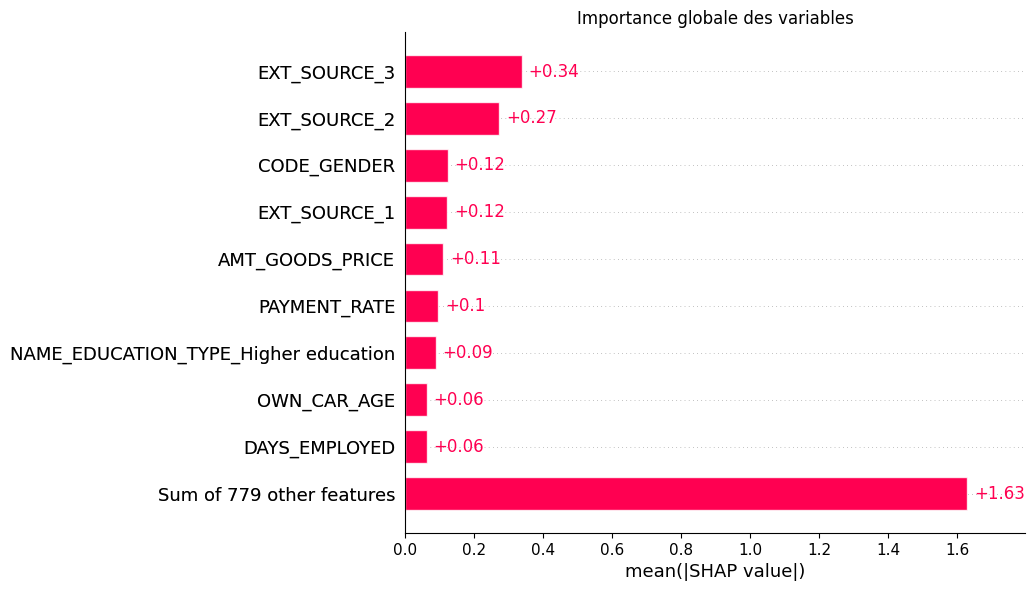

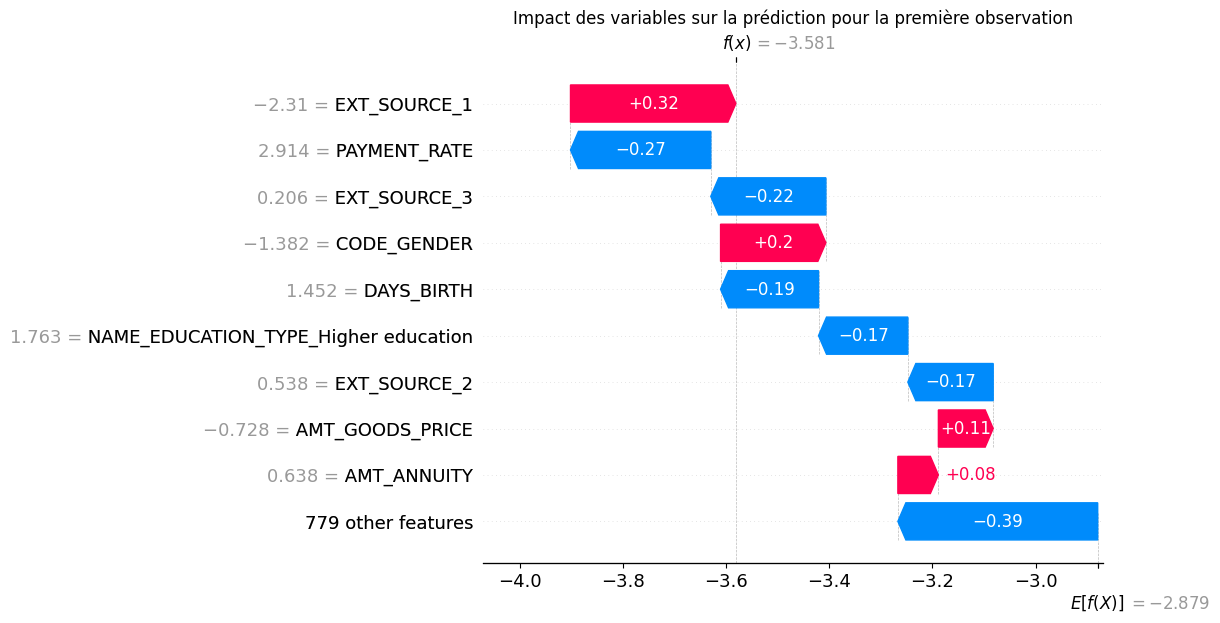

Application du modèle et Feature importance - done in 484s


2025/01/16 17:27:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Projet7_Scoring_model'.
Created version '1' of model 'Projet7_Scoring_model'.


Predicted   0.0  1.0
Actual              
0.0        4155   10
1.0         373    2


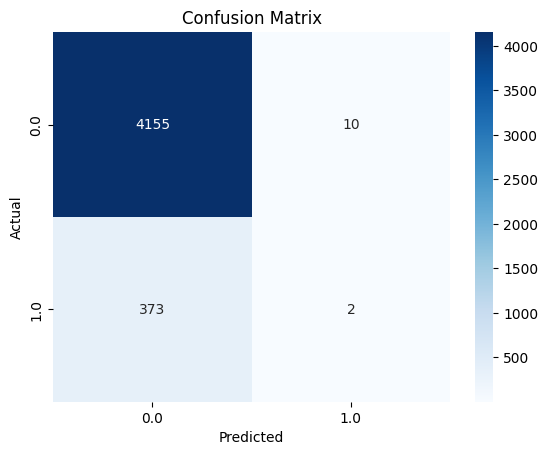

In [ ]:
import os
# Utiliser le pipeline chargé
with mlflow.start_run() as run:
  best_model, df_results, best_model_params,X_train, X_val, y_train, y_val,X,y,fig1, fig2, fig3,feature_global,feature_local,test_df,df6= pipeline_charge(
    num_rows=50000,  # Lire toutes les lignes
    nan_as_category=True,
    cost_matrix=cost_matrix)
  signature= infer_signature(X_train, best_model.predict(X_val))

  mlflow.sklearn.log_model(best_model, "mon_model", signature=signature)
  mlflow.log_params(best_model_params)

  # Calculate metrics and log them
  optimized_metrics = optimize_threshold_and_metrics(y_val, best_model.predict_proba(X_val)[:, 1], cost_matrix)
  mlflow.log_metrics({
                      "accuracy_train": accuracy_score(y_train, best_model.predict(X_train)),
                      "accuracy_val": accuracy_score(y_val, best_model.predict(X_val)),
                      "precision": precision_score(y_val, best_model.predict(X_val)),
                      "recall": recall_score(y_val, best_model.predict(X_val)),
                      "f1": f1_score(y_val, best_model.predict(X_val)),
                      "Score métier": optimized_metrics["business_score"],
                      "AUC": optimized_metrics["auc_score"]
                  })

  os.makedirs("figures", exist_ok=True)

  # Save and log figures using fig.write_image
  fig1.write_image("figures/comparaison_scores_metiers.png")
  fig2.write_image("figures/courbes_roc_auc.png")
  fig3.write_image("figures/temps_execution.png")
  mlflow.log_artifact("figures/comparaison_scores_metiers.png")
  mlflow.log_artifact("figures/courbes_roc_auc.png")
  mlflow.log_artifact("figures/temps_execution.png")

  # Save and log the DataFrame
  df_results.to_csv("figures/df_results.csv", index=False)
  mlflow.log_artifact("figures/df_results.csv")

  # Save and log SHAP figures
  feature_global_fig = feature_global.get_figure()
  feature_local_fig = feature_local.get_figure()
  feature_global_fig.savefig("figures/feature_importance_global.png")
  feature_local_fig.savefig("figures/feature_importance_local.png")
  mlflow.log_artifact("figures/feature_importance_global.png")
  mlflow.log_artifact("figures/feature_importance_local.png")

  # --- Continued from previous response ---
  model_info = mlflow.sklearn.log_model(
      sk_model=best_model,
      artifact_path="Scoring_model",
      registered_model_name="Projet7_Scoring_model"
  )

  # Load the model back for predictions as a generic Python Function model
  loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

  # Make predictions
  predictions = loaded_model.predict(X_val)

  # Create a DataFrame with predictions and actual values
  scoring_feature_names = X.columns
  result = pd.DataFrame(X_val, columns=scoring_feature_names)
  result["actual_class"] = y_val
  result["predicted_class"] = predictions
  result["prediction_proba"] = best_model.predict_proba(X_val)[:, 1]

  # Create and print confusion matrix
  confusion_matrix = pd.crosstab(
      result["actual_class"],
      result["predicted_class"],
      rownames=["Actual"],
      colnames=["Predicted"]
  )
  print(confusion_matrix)
  heatmap=sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  plt.title("Confusion Matrix")
  plt.show()
  heatmap.get_figure().savefig("figures/confusion_matrix.png")
  mlflow.log_artifact("figures/confusion_matrix.png")



In [ ]:
df6.to_csv('df6.csv', index=False)

In [ ]:
joblib.dump(best_model, 'best_model.joblib')
signature=infer_signature(X_train, y_train)

In [ ]:
#best_model.fit(X_train, y_train)

#Les tests unitaires

In [ ]:
!pytest

======================================= test session starts ========================================
platform linux -- Python 3.11.11, pytest-8.3.4, pluggy-1.5.0
rootdir: /content
plugins: ngrok-0.0.4, anyio-3.7.1, typeguard-4.4.1
collected 6 items                                                                                  

drive/MyDrive/Tests/tests/test_mon_code.py ......                                            [100%]

========================================= warnings summary =========================================
drive/MyDrive/Tests/tests/test_mon_code.py::TestPreprocessingFunctions::test_application_train_test
  /content/drive/MyDrive/Tests/tests/my_functions.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
  The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.
  
  For ex